In [1]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize
from datetime import timedelta
import yfinance as yf
import warnings
warnings.simplefilter(action="ignore")

In [2]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [3]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["AMZN","NVDA","AAPL","META","GOOGL","TSLA","MSFT"]
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [4]:
market_caps = {}
for ticker in tqdm(index["ticker"]):
    try:
        stock_info = yf.Ticker(ticker).info
        market_caps[ticker] = stock_info['marketCap']
    except KeyError:
        market_caps[ticker] = None  # Handle missing data

# Convert to DataFrame
market_caps_df = pd.DataFrame(list(market_caps.items()), columns=['ticker', 'market_cap'])

print(market_caps_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [00:52<00:00,  9.60it/s]

    ticker    market_cap
0      MMM  7.089068e+10
1      AOS  9.922008e+09
2      ABT  1.994456e+11
3     ABBV  3.145686e+11
4      ACN  2.227835e+11
..     ...           ...
497    XYL  2.855332e+10
498    YUM  3.773891e+10
499   ZBRA  2.006823e+10
500    ZBH  2.127504e+10
501    ZTS  7.426176e+10

[502 rows x 2 columns]


In [76]:
market.connect()
factors_df = []
for ticker in tqdm(factors):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["adjclose"] = price["adjclose"].shift(60)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
factors_df = pd.concat(factors_df).sort_values("date").pivot_table(index=["date"],columns="ticker",values="adjclose").reset_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 19.49it/s]


In [77]:
model_start = 2013
model_end = 2020
backtest_end = 2025

In [78]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = factors_df.merge(price[["date","ticker","adjclose"]],on="date",how="left")
        price["year"] = price["date"].dt.year
        price["quarter"] = price["date"].dt.quarter
        price["y"] = price["adjclose"].shift(-60)
        training_data = price[(price["year"]>=model_start) & (price["year"] < model_end)].dropna(subset=factors).dropna()
        sim = price[(price["year"]>=model_end-1) & (price["year"]<backtest_end)].dropna(subset=factors)
        model = XGBRegressor()
        model.fit(training_data[factors],training_data["y"])
        sim["prediction"] = model.predict(sim[factors])
        sim = sim.merge(macro,on="date",how="left")
        sim = CAPM.apply(sim)
        prices.append(sim)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 12%|██████████████████▉                                                                                                                                      | 62/502 [00:11<01:02,  7.04it/s]

'date'


 15%|███████████████████████▍                                                                                                                                 | 77/502 [00:13<01:03,  6.69it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [01:31<00:00,  5.49it/s]

'date'


In [79]:
simulation = pd.concat(prices).merge(index,on="ticker",how="left").merge(market_caps_df,on="ticker",how="left")
simulation["year"] = simulation["date"].dt.year
simulation["quarter"] = simulation["date"].dt.quarter
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna(subset="factor")
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]
simulation["rank"] = simulation.groupby(["date", "GICS Sector"])["factor"].rank(method="dense", ascending=False).astype(int)

# Calculate the total number of ranks for each sector and date
simulation["total_ranks"] = simulation.groupby(["date", "GICS Sector"])["rank"].transform("max")

# Assign exposure based on rank
simulation["exposure"] = simulation.apply(
    lambda x: 1 if x["rank"] <= x["total_ranks"] * 0.50 else -1,
    axis=1
)

# Cleanup: Drop the total_ranks column if not needed
simulation.drop(columns=["total_ranks"], inplace=True)

# Sorting by date for further processing
simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]

In [80]:
benchmark = macro.copy()
benchmark["year"] = benchmark["date"].dt.year
benchmark["quarter"] = benchmark["date"].dt.quarter
benchmark = benchmark[(benchmark["year"]>=model_end) & (benchmark["year"]<backtest_end)].drop([x for x in benchmark.columns if "real" in x],axis=1).groupby(["year","quarter"]).mean().reset_index()
benchmark["sp500"] = (benchmark["sp500"] - benchmark["sp500"].iloc[0]) /benchmark["sp500"].iloc[0]
benchmark["rf"] = (benchmark["rf"] - benchmark["rf"].iloc[0]) /benchmark["rf"].iloc[0]
benchmark["sp500_prediction"] = (benchmark["sp500_prediction"] - benchmark["sp500_prediction"].iloc[0]) /benchmark["sp500_prediction"].iloc[0]
benchmark.dropna(inplace=True)

In [81]:
def rank_list(value,i):
    # Ensure i is a non-negative integer
    if value == 0:
        if i < 0:
            raise ValueError("The number of integers, i, must be non-negative.")
        
        if i % 2 == 0:
            # Even number of elements: Symmetric around 0
            return list(range(-i // 2, i // 2))
        else:
            # Odd number of elements: Includes 0
            return list(range(-i // 2, i // 2 + 1))
    if value == -1:
        return list(range(-1,-i-1,-1))
    else:
        return list(range(0,i+1,1))

In [82]:
filtered_columns = ["year","quarter","date","sell_date","GICS Sector","ticker","rank","exposure","adjclose","sell_price"]
agg_query = {"date":"first","sell_date":"last","GICS Sector":"first","exposure":"first","rank":"first","adjclose":"first","sell_price":"last"}

In [83]:
simulation.tail()

,date,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA,ticker,adjclose,...,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded,market_cap,rank,exposure,sell_price,sell_date
506797,2024-10-10,228.365709,187.93,180.570942,461.187847,441.843097,117.971965,248.5,NKE,81.686866,...,"Apparel, Accessories & Luxury Goods","Washington County, Oregon",1988-11-30,320187.0,1964,1.137512e+11,16,1,81.686866,2024-10-10
508301,2024-10-10,228.365709,187.93,180.570942,461.187847,441.843097,117.971965,248.5,NI,33.487605,...,Multi-Utilities,"Merrillville, Indiana",2000-11-02,1111711.0,1912,1.715880e+10,28,-1,33.487605,2024-10-10
509805,2024-10-10,228.365709,187.93,180.570942,461.187847,441.843097,117.971965,248.5,NDSN,253.600000,...,Industrial Machinery & Supplies & Components,"Westlake, Ohio",2022-02-15,72331.0,1935,1.204577e+10,50,-1,253.600000,2024-10-10
467693,2024-10-10,228.365709,187.93,180.570942,461.187847,441.843097,117.971965,248.5,MET,83.448053,...,Life & Health Insurance,"New York City, New York",2000-12-11,1099219.0,1868,5.695154e+10,51,-1,83.448053,2024-10-10
750445,2024-10-10,228.365709,187.93,180.570942,461.187847,441.843097,117.971965,248.5,ZBH,102.820000,...,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869.0,1927,2.127504e+10,22,1,102.820000,2024-10-10


In [84]:
run = True
if run:
    analysises = []
    for direction in tqdm([1,-1]):
        for value in tqdm([1,0,-1]):
            for maximum_index in tqdm([1,50,100,200]):
                for minimum_index in [0,50,100,200]:
                    for num_stocks_per_industry in [1,5]:
                        try:
                            parameters = {
                                "direction":direction,
                                "val":value,
                                "maxi": maximum_index,
                                "mini": minimum_index,
                                "stacks": num_stocks_per_industry
                            }
                            stacks = rank_list(value,num_stocks_per_industry)
                            max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
                            min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
                            filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
                            trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
                            trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","GICS Sector"]).nth(stacks).reset_index()
                            trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
                            trades["return"] = trades["return"] * trades["exposure"] * direction 
                            analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
                            portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
                            portfolio["return"] = portfolio["return"] + 1
                            portfolio["return"] = portfolio["return"].cumprod() - 1
                            portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
                            portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")
                            portfolio["sharpe"] = portfolio["return"] - portfolio["rf"] / portfolio["return"].std()
                            parameters["risk"] = portfolio["return"].std()
                            parameters["sharpe"] = portfolio["sharpe"].iloc[-1]
                            parameters["return"] = portfolio["return"].iloc[-1]
                            analysises.append(parameters)
                        except Exception as e:
                            print(str(e))
                            continue

  0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                                    | 0/4 [00:00<?, ?it/s]

 25%|███████████████████████████████████████                                                                                                                     | 1/4 [00:07<00:23,  7.74s/it]

 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 2/4 [00:14<00:14,  7.45s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 3/4 [00:22<00:07,  7.44s/it]

100%|██████████████████████████████

In [85]:
a = pd.DataFrame(analysises)
a["color"] = ["blue" if x == 1 else "red" if x == -1  else "green" for x in a["val"]]
a["return_to_risk"] = a["return"] / a["risk"]

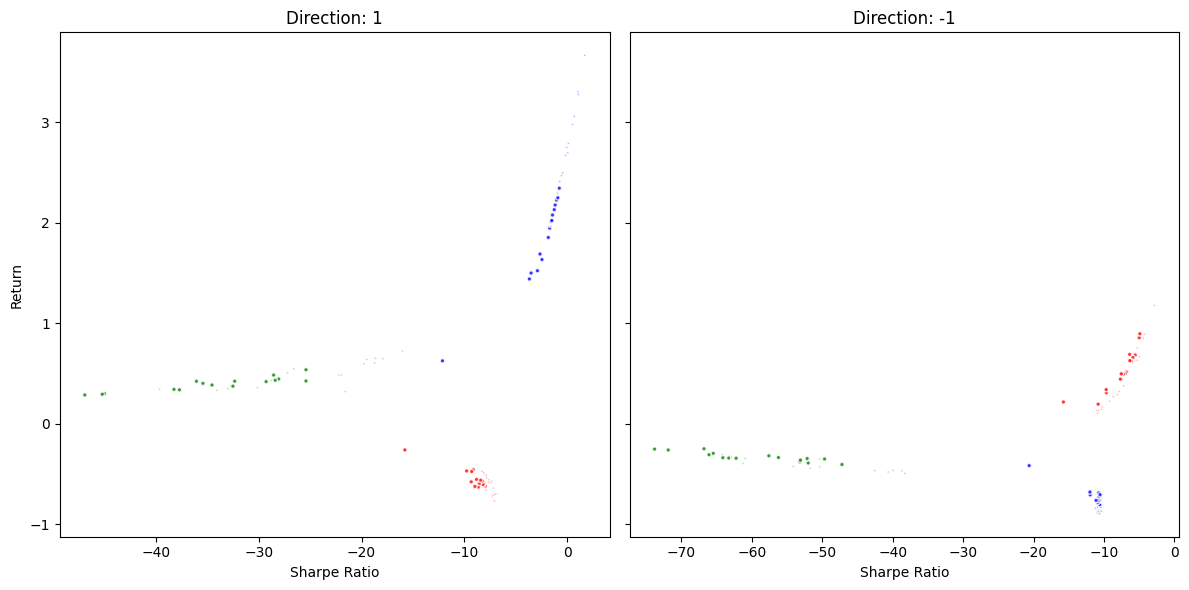

In [86]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Direction: 1", "Direction: -1"]

# Iterate over directions and corresponding axes
for i, direction in enumerate([1, -1]):
    d_analysis = a[a["direction"] == direction]
    axes[i].scatter(
        d_analysis["sharpe"],
        d_analysis["return"],
        c=d_analysis["color"],
        s=d_analysis["stacks"] * 2,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Sharpe Ratio")
    axes[i].set_ylabel("Return" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [87]:
a.sort_values("return",ascending=False).head(20)

,direction,val,maxi,mini,stacks,risk,sharpe,return,color,return_to_risk
4,1,1,1,100,1,0.974378,1.722572,3.664264,blue,3.760619
2,1,1,1,50,1,0.846171,1.064427,3.300311,blue,3.900287
6,1,1,1,200,1,0.878545,1.122766,3.276261,blue,3.729192
20,1,1,100,100,1,0.804915,0.706930,3.057416,blue,3.798434
12,1,1,50,100,1,0.781043,0.553564,2.975890,blue,3.810147
18,1,1,100,50,1,0.712752,0.132788,2.787206,blue,3.910486
0,1,1,1,0,1,0.685286,-0.014448,2.746357,blue,4.007606
22,1,1,100,200,1,0.725941,0.086721,2.692913,blue,3.709548
10,1,1,50,50,1,0.676052,-0.128503,2.670013,blue,3.949422
14,1,1,50,200,1,0.653950,-0.400051,2.493049,blue,3.812295


In [88]:
value = 1
direction = 1
maximum_index = 1
minimum_index = 100
num_stocks_per_industry = 1
stacks = rank_list(value,num_stocks_per_industry)

In [89]:
stacks = rank_list(value,num_stocks_per_industry)
max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","GICS Sector"]).nth(stacks).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"] * direction 
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")

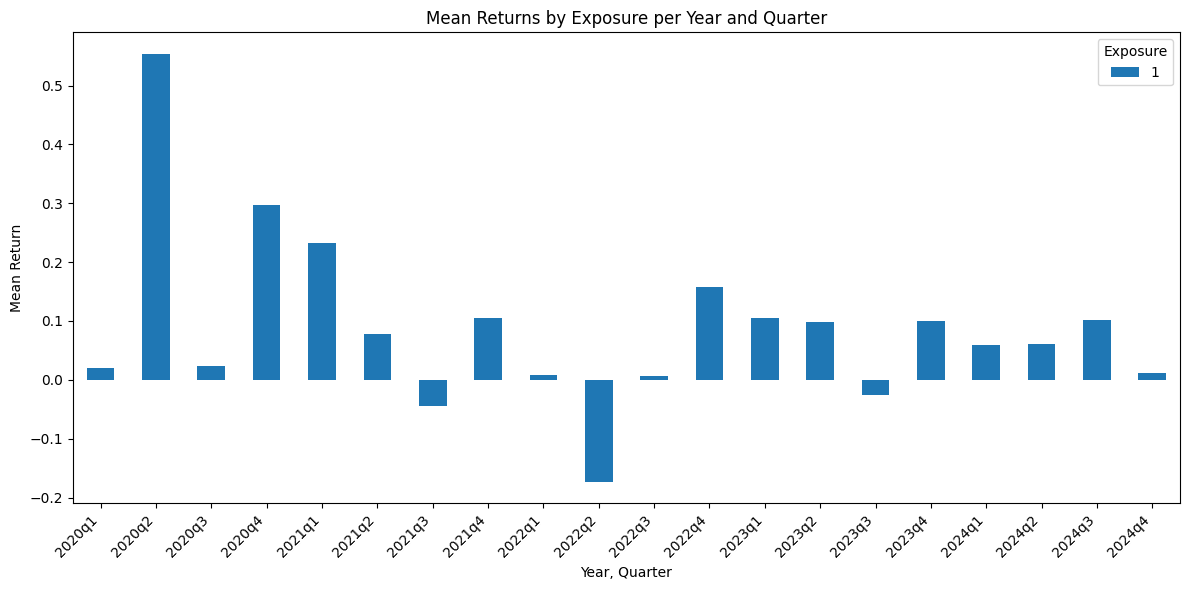

In [90]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


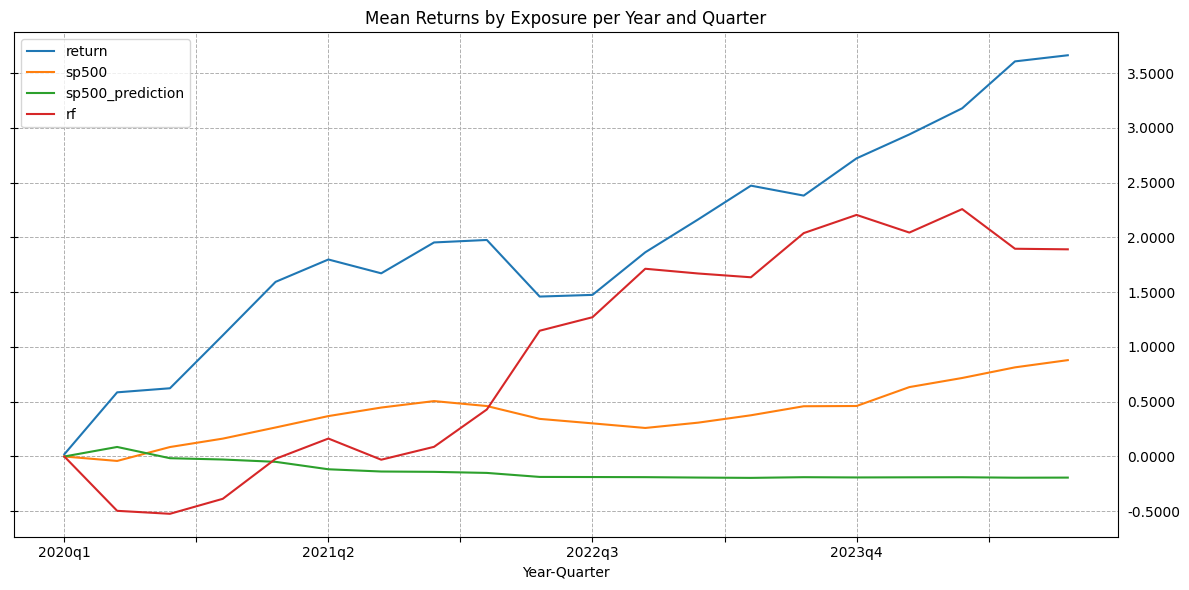

In [91]:
# Create the plot
ax = portfolio.drop(["date", "year", "quarter"], axis=1).set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [92]:
portfolio.tail()

,year,quarter,return,Year-Quarter,date,sp500,sp500_prediction,rf
15,2023,4,2.722693,2023q4,2023-11-14 05:42:51.428571392,0.461093,-0.191385,2.206233
16,2024,1,2.941189,2024q1,2024-02-14 09:50:09.836065536,0.633755,-0.190196,2.044977
17,2024,2,3.179860,2024q2,2024-05-14 06:05:42.857142784,0.716902,-0.189471,2.259143
18,2024,3,3.608270,2024q3,2024-08-15 01:52:30.000000000,0.814040,-0.193665,1.897207
19,2024,4,3.664264,2024q4,2024-10-06 02:40:00.000000000,0.879934,-0.192846,1.891941


In [93]:
trades.groupby(["year","quarter","exposure","GICS Sector"]).agg({"return":"mean"}).tail(22)

return
year quarter exposure GICS Sector                     
2024 3       1        Communication Services  0.099011
                      Consumer Discretionary -0.029541
                      Consumer Staples        0.085358
                      Energy                 -0.076285
                      Financials              0.176080
                      Health Care             0.031028
                      Industrials             0.273279
                      Information Technology  0.122543
                      Materials               0.130097
                      Real Estate             0.078748
                      Utilities               0.237116
     4       1        Communication Services -0.038249
                      Consumer Discretionary  0.079140
                      Consumer Staples       -0.019000
                      Energy                  0.058043
                      Financials              0.031182
                      Health Care             0.003700
                      Industrials             0.036436
                      Information Technology  0.026438
                      Materials              -0.006356
                      Real Estate            -0.007376
                      Utilities              -0.030300

In [94]:
print(((macro["sp500"].pct_change().cumsum().iloc[-1]+1) ** (1/6))/macro["sp500"].pct_change().cumsum().std())

4.672939581907131
